In [1]:
# 影像前處理_灰階&二值化
import cv2
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
import os
jtplot.style('onedork',grid=False,figsize=(8.0, 9.0)) #畫圖風格

input_path='./img/t007_03.jpg'
output_path='./output/'
name=os.path.basename(input_path)
img1=cv2.imread(input_path)
#Load File
height,width, value = img1.shape
print('width_{},height_{}'.format(width,height))

#灰階
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) #grayscale conversion
blurred = cv2.GaussianBlur(gray, (5, 5), 0) # 用高斯平滑處理原影象降噪 
table1=pd.DataFrame(blurred.reshape(height, width)) 
table1.to_csv('./img/blurred.csv')
plt.imshow(blurred,cmap='gray')
plt.title('Gray')
plt.show()

#二值化，留Mark
thresh = 150
mark_Bin= cv2.threshold(blurred, thresh, 255, cv2.THRESH_BINARY)[1] 
plt.imshow(mark_Bin,cmap='gray')
plt.title('BIN_Mark')
plt.show()

#二值化，留切割
thresh = 110
cut_Bin = cv2.threshold(blurred, thresh, 255, cv2.THRESH_BINARY)[1] 
plt.imshow(cut_Bin,cmap='gray')
plt.title('BIN_Cut')
plt.show()
# ary = np.array(cut_Bin) #將二值後的資料轉Array
# table=pd.DataFrame(ary.reshape(height, width)) # reshape to image size and transfer to Dataframe
# table.to_csv('C:/Users/seanchlin/AI_project/X_ray_cutting_IMT/img/pixle.csv')

width_480,height_404


<Figure size 640x720 with 1 Axes>

<Figure size 640x720 with 1 Axes>

<Figure size 640x720 with 1 Axes>

In [2]:
### 二值化&霍夫曼直線
def line(im_Bin,Im):
    # Erosion 影像侵蝕(二值化後)
    kernel = np.ones((3,3), np.uint8)
    erosion = cv2.erode(im_Bin, kernel, iterations = 3)
    plt.imshow(cv2.cvtColor(erosion,cv2.COLOR_GRAY2RGB))
    plt.title('erosion')
    # plt.show()
    # #Dilation 影像膨脹(二值化後)
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(erosion, kernel, iterations = 3) #執行越多次膨脹效果越明顯
    plt.imshow(cv2.cvtColor(dilation,cv2.COLOR_GRAY2RGB))
    plt.title('Dilation')
    # plt.show()
    #canny邊緣檢測
    canny = cv2.Canny(dilation, 30, 150) #low_threshold:30, high_threshold:150
    cv2.imwrite(output_path +'Canny_'+input_path.split('/')[-1], canny)
    plt.imshow(cv2.cvtColor(canny,cv2.COLOR_GRAY2RGB))
    plt.title('Canny')
    plt.show()
    #直線檢測--霍夫直線變換
    #threshold:判斷直線點數的閾值; minLineLength：短於此的線段將被拒絕; maxLineGap 線段之間允許的最大間隙，將它們視為一條線
    lines = cv2.HoughLinesP(canny, 1, np.pi / 180, 50, minLineLength=30, maxLineGap=1) #霍夫直線變換
    lines1 = lines[:, 0, :]  # 提取為二維
    for x1, y1, x2, y2 in lines1[:]:
        if (((10<x1<470)or(10<x2<470))and((10<y1<420)or(10<y2<420))):
            cv2.line(Im, (x1, y1), (x2, y2), (0, 255, 0), 2)
    #     print('x1:{} y1:{} x2:{} y2:{}'.format(x1,y1,x2,y2))
    # cv2.imwrite('C:/Users/seanchlin/AI_project/Sample code/test_img/HoughLines.jpg', img1)
    plt.imshow(Im)
    cv2.imwrite(output_path +'Result_'+input_path.split('/')[-1],Im)
    plt.title('Result')
    plt.show()
    #判斷斜率
    i=1
    vline=[]
    hline=[]
    # 對通過霍夫變換得到的資料進行遍歷
    for line in lines:
        # newlines1 = lines[:, 0, :]
        print("line["+str(i-1)+"]=",line)
        x1,y1,x2,y2 = line[0]  #兩點確定一條直線，這裡就是通過遍歷得到的兩個點的資料 （x1,y1）(x2,y2)
    #     cv2.line(img1,(x1,y1),(x2,y2),(0,0,255),2)   #在原圖上畫線
        # 轉換為浮點數，計算斜率
        x1 = float(x1)
        x2 = float(x2)
        y1 = float(y1)
        y2 = float(y2)
        print ("x1=%s,x2=%s,y1=%s,y2=%s" % (x1, x2, y1, y2))
        #判斷垂直線&定義的範圍
        if ((x2 - x1 == 0 )and(((10<x1<470)or(10<x2<470))and((10<y1<420)or(10<y2<420)))):
    #         print("line["+str(i-1)+"]=",line)
    #         print ("x1=%s,x2=%s,y1=%s,y2=%s" % (x1, x2, y1, y2))
            print ("V-Line")
            print("Lenth",y2-y1)
            result=90
            #記錄所有垂直線的x座標，最大-最小得出垂直線之間的距離
            vline.append(x1)
        #判斷水平線&定義的範圍
        elif ((y2 - y1 == 0) and (((10<x1<470)or(10<x2<470))and((10<y1<420)or(10<y2<420)))):
            print ("H-Line")
            print("Lenth",x2-x1)
            result=0
            #記錄所有水平線的y座標，最大-最小得出水平線之間的距離
            hline.append(y1)
        else:
            # 計算斜率
            k = -(y2 - y1) / (x2 - x1)
            # 求反正切，再將得到的弧度轉換為度
            result = np.arctan(k) * 57.29577
            print ("Line-Angle：" + str(result) + "degree")
        print('============================')
        i = i+1
    print('V_line_list', sorted(vline))
    print('H_line_list',sorted(hline))
    # x/y 座標，最大-最小得出垂直/水平線之間的距離
    print('V_line_gap %s pixel'% str(max(vline)-min(vline)))
    print('H_line_gap %s pixel'% str(max(hline)-min(hline)))
    #return 垂直線&水平線的中心點value，min + (max-min)/2
    return(min(vline)+float(max(vline)-min(vline))/2,float(min(hline))+float(max(hline)-min(hline))/2)

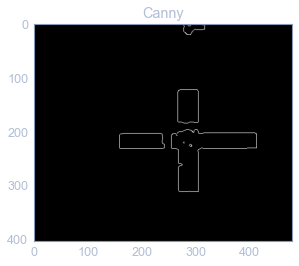

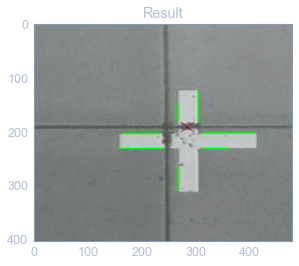

line[0]= [[159 232 239 232]]
x1=159.0,x2=239.0,y1=232.0,y2=232.0
H-Line
Lenth 80.0
line[1]= [[304 183 304 126]]
x1=304.0,x2=304.0,y1=183.0,y2=126.0
V-Line
Lenth -57.0
line[2]= [[314 203 409 203]]
x1=314.0,x2=409.0,y1=203.0,y2=203.0
H-Line
Lenth 95.0
line[3]= [[164 204 235 204]]
x1=164.0,x2=235.0,y1=204.0,y2=204.0
H-Line
Lenth 71.0
line[4]= [[266 149 266 182]]
x1=266.0,x2=266.0,y1=149.0,y2=182.0
V-Line
Lenth 33.0
line[5]= [[313 232 361 232]]
x1=313.0,x2=361.0,y1=232.0,y2=232.0
H-Line
Lenth 48.0
line[6]= [[267 309 267 267]]
x1=267.0,x2=267.0,y1=309.0,y2=267.0
V-Line
Lenth -42.0
V_line_list [266.0, 267.0, 304.0]
H_line_list [203.0, 204.0, 232.0, 232.0]
V_line_gap 38.0 pixel
H_line_gap 29.0 pixel
285.0 217.5


In [4]:
#找Mark中心點
Im=cv2.imread('./img/t007_03.jpg')
mark_x,mark_y=line(mark_Bin,Im)
print(mark_x,mark_y)

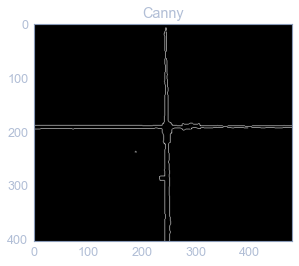

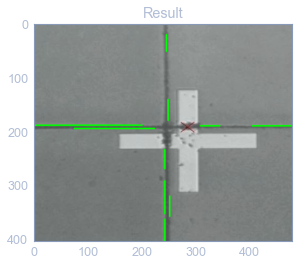

line[0]= [[242 403 242 363]]
x1=242.0,x2=242.0,y1=403.0,y2=363.0
V-Line
Lenth -40.0
line[1]= [[ 74 195 223 195]]
x1=74.0,x2=223.0,y1=195.0,y2=195.0
H-Line
Lenth 149.0
line[2]= [[404 190 479 190]]
x1=404.0,x2=479.0,y1=190.0,y2=190.0
H-Line
Lenth 75.0
line[3]= [[  0 189 200 189]]
x1=0.0,x2=200.0,y1=189.0,y2=189.0
H-Line
Lenth 200.0
line[4]= [[251 320 251 358]]
x1=251.0,x2=251.0,y1=320.0,y2=358.0
V-Line
Lenth 38.0
line[5]= [[242 353 242 292]]
x1=242.0,x2=242.0,y1=353.0,y2=292.0
V-Line
Lenth -61.0
line[6]= [[245  21 245  52]]
x1=245.0,x2=245.0,y1=21.0,y2=52.0
V-Line
Lenth 31.0
line[7]= [[308 190 344 190]]
x1=308.0,x2=344.0,y1=190.0,y2=190.0
H-Line
Lenth 36.0
line[8]= [[248 141 248 180]]
x1=248.0,x2=248.0,y1=141.0,y2=180.0
V-Line
Lenth 39.0
line[9]= [[242 270 242 234]]
x1=242.0,x2=242.0,y1=270.0,y2=234.0
V-Line
Lenth -36.0
V_line_list [242.0, 242.0, 242.0, 245.0, 248.0, 251.0]
H_line_list [189.0, 190.0, 190.0, 195.0]
V_line_gap 9.0 pixel
H_line_gap 6.0 pixel
246.5 192.0


In [5]:
#找切割線中心點
Im=cv2.imread('./img/t007_03.jpg')
cut_x,cut_y=line(cut_Bin,Im)
print(cut_x,cut_y)

In [11]:
# 切割精度 mark中心 & 切割中心 座標相減
print('x切割精度:{} pixel, y切割精度:{} pixel'.format(mark_x-cut_x,mark_y-cut_y))

x切割精度:38.5 pixel, y切割精度:25.5 pixel
